In [154]:
# commerical device class
class CommercialDevice:
    def __init__(self, brand, model):
        self.brand = brand
        self.model = model

    def get_device_info(self):
        """Retrieve brand and model name of a device.

        Paramters
        ---------
        None

        Returns
        -------
        device_info : str
        """
        device_info = f"{self.brand} - {self.model}"
        return device_info

    def calculate_rescale_value(self, age, is_damaged):
        """Short descreption

        Long description

        Parameters
        ----------
        age : int
            Description for parameter
        is_damaged : bool
            Description

        Return
        ------

        """
        initial_value = 1000
        depre_rate = 0.20 if self.brand == "Apple" else 0.15
        rescale_value = initial_value * ((1 - depre_rate) ** age)
        if is_damaged:
            rescale_value *= 0.70

        return round(rescale_value, 2)
        

In [157]:
import json
from xml.dom import minidom
import xml.etree.ElementTree as e_tree
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, skew, kurtosis
from scipy.linalg import svd
import itertools
pd.options.mode.chained_assignment = None

In [153]:
class Apple_Watch(CommercialDevice):
    """
    A class to parse AppleWatch xml directly

    ...

    Attributes
    ----------
    file : str
        filepath of export.xml

    Methods
    -------
    xml_to_json()
        converts xml to json
    parse()
        parses xml to pandas dataframe
    get_source(source=str)
        returns dataframe with specific source (Apple Watch, iPhone, etc)
    get_type(health_data=str)
        returns dataframe with specific health data (HeartRate, SleepAnalysis, etc)
    get_data()
        returns filled dataframe
    get_heartrate_for_date(start=dt.date(year,month,day), end=dt.date(year,month,day)
        returns heartrate dataframe for specific date range
    get_sleep_for_date(start=dt.date(year,month,day), end=dt.date(year,month,day)
    returns sleep dataframe for specific date range
    get_statistics(df=DataFrame, ent=bool, p_ent=bool, s_ent=bool)
        returns statistics on inputted dataframe
    """

    def __init__(self, file) -> None:
        """
        Parameters
        ----------
        file : str
            filepath of export.xml
        """
        self.file = file
        self.dataframe = None
        self.sleep = None
        self.energy = None
        self.steps = None
        self.distance = None
        self.oxygen = None
        self.heart_rate = None

    @classmethod
    def from_file(cls, file, fill):
      apple_watch = cls(file)
      apple_watch.parse(fill)

      return apple_watch

    # PREPROCESSING
    def parse(self, option):
        """
        Parameters
        ----------
        option : str (fill, else)
            type of nan processing
        """
        tree = e_tree.parse(self.file)
        root = tree.getroot() # get the root of the xml file
        record_list = [x.attrib for x in root.iter('Record')]
        record_data = pd.DataFrame(record_list)

        # proper type to dates
        for col in ['creationDate', 'startDate', 'endDate']:
            record_data[col] = pd.to_datetime(record_data[col])

        # sleep data has types stored in value, so deal with it seperately
        local_sleep_data = record_data[record_data['type'] == 'HKCategoryTypeIdentifierSleepAnalysis']
        local_sleep_data['value'] = local_sleep_data['value'].str.replace('HKCategoryValueSleepAnalysis', '')

        # nan is non numeric value
        record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce')

        # deal with missing data
        if option == "fill":
          record_data['value'] = record_data['value'].ffill()
          record_data['value'] = record_data['value'].bfill()
        else:
          # some records do not measure anything, just count occurences
          record_data['value'] = record_data['value'].fillna(1.0)

        # shorter observation names
        record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '')
        record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')

        #record_data.index = pd.to_datetime(record_data.index)
        record_data = record_data[record_data['sourceName'] == "Shun’s Apple Watch"]


        self.dataframe = record_data
        self.heart_rate = self.get_heart_rate()
        self.energy = self.get_active_energy()
        self.distance = self.get_distance()
        self.oxygen = self.get_spo2()
        self.steps = self.get_steps()
        self.sleep = self.get_sleep(local_sleep_data) #local_sleep_data[local_sleep_data['sourceName'] == "Shun’s Apple Watch"]

    
    # GETTERS
    def get_heart_rate(self):
        """
        Parameters
        ----------
        None
        """
        total_df = self.dataframe
        heart_rate_df = total_df[total_df["type"] == "HeartRate"]

        # preprocessing
        heart_rate_df.drop(columns=['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'startDate', 'device'], inplace=True)
        heart_rate_df.rename(columns={'endDate':'timestamp', 'value': 'heart_rate'}, inplace=True)
        heart_rate_df = heart_rate_df.astype({'heart_rate': 'int64'})

        return heart_rate_df

    def get_active_energy(self):
        """
        Parameters
        ----------
        None
        """
        total_df = self.dataframe
        active_energy_df = total_df[total_df["type"] == "ActiveEnergyBurned"]

        # preprocessing
        active_energy_df.drop(columns=['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'device'], inplace=True)
        active_energy_df.rename(columns={'startDate':'start_time', 'endDate':'end_time', 'value': 'active_calories'}, inplace=True)
        active_energy_df = active_energy_df.astype({'active_calories': 'int64'})

        return active_energy_df
    
    def get_distance(self):
        """
        Parameters
        ----------
        None
        """
        total_df = self.dataframe
        distance_df = total_df[total_df["type"] == "DistanceWalkingRunning"]

        # preprocessing
        distance_df.drop(columns=['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'device'], inplace=True)
        distance_df.rename(columns={'startDate':'start_time', 'endDate':'end_time', 'value': 'distance'}, inplace=True)

        return distance_df
    
    def get_spo2(self):
        """
        Parameters
        ----------
        None
        """
        total_df = self.dataframe
        spo2_df = total_df[total_df["type"] == "OxygenSaturation"]

        # preprocessing
        spo2_df.drop(columns=['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'startDate', 'device'], inplace=True)
        spo2_df.rename(columns={'endDate':'timestamp', 'value': 'SpO2'}, inplace=True)
        spo2_df['SpO2'] = spo2_df['SpO2'].apply(lambda x: x*100)
        spo2_df = spo2_df.astype({'SpO2': 'int64'})

        return spo2_df
    
    def get_steps(self):
        """
        Parameters
        ----------
        None
        """
        total_df = self.dataframe
        steps_df = total_df[total_df["type"] == "StepCount"]

        # preprocessing
        steps_df.drop(columns=['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'device'], inplace=True)
        steps_df.rename(columns={'startDate':'start_time', 'endDate':'end_time', 'value': 'steps'}, inplace=True)
        steps_df = steps_df.astype({'steps': 'int64'})

        return steps_df

    def get_sleep(self, data):
        """
        Parameters
        ----------
        None
        """

        sleep_df = data
        sleep_df['time_asleep'] = (sleep_df['endDate'] - sleep_df['startDate']).dt.total_seconds()

        # aggreagate

        # asleepLight = light
        light_df = sleep_df[sleep_df['value'].isin(['AsleepCore'])].groupby(['creationDate']).agg(
            creation_date=('creationDate', 'min'),
            total_light_sleep=('time_asleep', 'sum'),
        )

        # asleepDeep = deep
        deep_df = sleep_df[sleep_df['value'].isin(['AsleepDeep'])].groupby(['creationDate']).agg(
            creation_date=('creationDate', 'min'),
            total_deep_sleep=('time_asleep', 'sum'),
        )

        # asleepREM = rem
        rem_df = sleep_df[sleep_df['value'].isin(['AsleepREM'])].groupby(['creationDate']).agg(
            creation_date=('creationDate', 'min'),
            total_rem_sleep=('time_asleep', 'sum'),
        )

        # awake = awake
        awake_df = sleep_df[sleep_df['value'].isin(['Awake'])].groupby(['creationDate']).agg(
            creation_date=('creationDate', 'min'),
            total_awake_time=('time_asleep', 'sum'),
        )


        # join the tables
        agg_sleep_df = light_df.merge(deep_df, how='inner').merge(rem_df, how='inner').merge(awake_df, how='inner')

        # processing
        agg_sleep_df.rename(columns={'total_light_sleep':'light', 'total_deep_sleep':'deep', 'total_rem_sleep': 'REM', 'total_awake_time': 'awake'}, inplace=True)
        agg_sleep_df = agg_sleep_df.astype({'light': 'int64', 'deep': 'int64', 'REM': 'int64', 'awake': 'int64'})

        agg_sleep_df['creation_date'] = agg_sleep_df['creation_date'].apply(lambda x: x.date())

        return agg_sleep_df

    def output_csv(self):
        """
        Parameters
        ----------
        None
        """
        self.dataframe.to_csv("data.csv")


    def get_type(self, health_data):
        """
        Parameters
        ----------
        health_date : str
            name of health data (HeartRate, SleepAnalysis, etc)
        """
        return self.dataframe[self.dataframe["type"] == health_data]

    # SAMPLING
    def upsample_dataframe(self, rule='H', method='ffill'):
        """
        Upsample a DataFrame using the specified rule and fill method.

        Parameters:
            df (pd.DataFrame): Input DataFrame.
            rule (str): The offset string or object representing target conversion.
                        For example, 'H' for hourly, 'T' for minutely, 'S' for secondly, etc.
            method (str): Fill method for upsampling. Default is 'ffill' (forward fill).
                          Other options include 'bfill' (backward fill), None (no fill), etc.

        Returns:
            pd.DataFrame: Upsampled DataFrame.
        """
        upsampled_df = self.dataframe.resample(rule=rule).fillna(method=method)
        return upsampled_df

    def downsample_dataframe(self, rule='D', method='mean'):
        """
        Downsample a DataFrame using the specified rule and aggregation method.

        Parameters:
            df (pd.DataFrame): Input DataFrame.
            rule (str): The offset string or object representing target conversion.
                        For example, 'D' for daily, 'W' for weekly, 'M' for monthly, etc.
            method (str): Aggregation method for downsampling. Default is 'mean'.
                          Other options include 'sum', 'min', 'max', 'first', 'last', etc.

        Returns:
            pd.DataFrame: Downsampled DataFrame.
        """
        downsampled_df = self.dataframe.resample(rule=rule).apply(method)
        return downsampled_df

    # DATA OUTPUT RELATED FUNCTIONALITY
    def get_heartrate_for_date(self, start, end):
        """
        Parameters
        ----------
        start : dt.date(year,month,day)
            start date of range
        end : dt.date(year,month,day)
            end date of range

        """
        st = pd.to_datetime(start, utc=True)
        e = pd.to_datetime(end, utc=True)

        # get the heart rate data
        hr_data = self.heart_rate

        # get particular range
        hr_range = hr_data[hr_data["startDate"] >= st]
        hr_range = hr_range[hr_range["endDate"] <= e]

        hr_range.set_index('startDate', inplace=True)
        average_heart_rate_per_day = hr_range.groupby(hr_range.index.date)['value'].mean()
        print(average_heart_rate_per_day)

        return average_heart_rate_per_day

    def get_sleep_for_date(self, start, end):
        """
        Parameters
        ----------
        start : dt.date(year,month,day)
            start date of range
        end : dt.date(year,month,day)
            end date of range

        """
        st = pd.to_datetime(start, utc=True)
        e = pd.to_datetime(end, utc=True)

        sleep_data = self.sleep
        sleep_data = sleep_data[sleep_data['sourceName'] == "Shun’s Apple Watch"]

        # get particular range
        sleep_data = sleep_data[sleep_data["startDate"] >= st]
        sleep_data = sleep_data[sleep_data["endDate"] <= e]

        sleep_data['time_asleep'] = sleep_data['endDate'] - sleep_data['startDate']

        # aggreagate
        sleep_data = sleep_data.groupby('creationDate').agg(
            total_time_asleep=('time_asleep', 'sum'),
            bed_time=('startDate', 'min'),
            awake_time=('endDate', 'max'),
            sleep_counts=('creationDate','count')
        )

        sleep_data['time_in_bed'] = sleep_data['awake_time'] - sleep_data['bed_time']
        sleep_data['restless_time'] = sleep_data['time_in_bed'] - sleep_data['total_time_asleep']
        sleep_data['time_in_bed'] = (sleep_data['time_in_bed'].dt.total_seconds()/60)
        sleep_data['total_time_asleep'] = (sleep_data['total_time_asleep'].dt.total_seconds()/60)

        return sleep_data

    def get_statistics(self, df, ent=False, p_ent=False, s_ent=False):
        """
        Parameters
        ----------
        df : Pandas DataFrame
            dataframe to perform statistical analysis on
        ent : Bool
            whether or not to calculate entropy
        p_ent : Bool
            whether or not to calculate perm_entropy
        s_ent : Bool
        end : dt.date(year,month,day)
            whether or not to calculate svd_entropy

        """
        statistics = {}

        if isinstance(df, pd.Series): # change to df if its a dataseries
          df = df.to_frame()

        if ent:
            statistics['entropy'] = entropy(df.values.flatten())
        if p_ent:
            data = df.values.flatten()
            permutations = itertools.permutations(data, 3)
            unique_permutations = set(permutations)
            permutation_counts = [data.tolist().count(perm) for perm in unique_permutations]
            probabilities = [count / len(data) for count in permutation_counts]
            statistics['perm_entropy'] = -sum(p * np.log2(p) for p in probabilities if p != 0)
        if s_ent:
            s_data = df.values
            U, S, VT = svd(s_data)
            normalized_singular_values = S / np.sum(S)
            statistics['svd_entropy'] = -np.sum(normalized_singular_values * np.log2(normalized_singular_values))

        # Calculate mean, min, max, ptp, sum, energy, skewness, and kurtosis
        statistics['mean'] = df.mean().values.flatten()
        statistics['min'] = df.min().values.flatten()
        statistics['max'] = df.max().values.flatten()
        #statistics['ptp'] = df.ptp().values.flatten()
        statistics['sum'] = df.sum().values.flatten()
        statistics['energy'] = np.sum(np.square(df.values.flatten()))
        statistics['skewness'] = skew(df.values.flatten())
        statistics['kurtosis'] = kurtosis(df.values.flatten())

        # peaks?

        # Calculate root mean square (RMS)
        statistics['rms'] = np.sqrt(np.mean(np.square(df.values.flatten())))

        # Calculate line integral
        statistics['lineintegral'] = np.sum(np.abs(np.diff(df.values.flatten())))

        # Calculate number of values above and below mean
        mean_value = df.values.mean()
        statistics['n_above_mean'] = np.sum(df.values.flatten() > mean_value)
        statistics['n_below_mean'] = np.sum(df.values.flatten() < mean_value)

        # Calculate interquartile range (IQR), 5th and 95th percentiles
        statistics['iqr'] = df.quantile(0.75) - df.quantile(0.25)
        statistics['iqr_5_95'] = df.quantile(0.95) - df.quantile(0.05)
        statistics['pct_5'] = df.quantile(0.05)
        statistics['pct_95'] = df.quantile(0.95)

        return statistics
        

In [158]:
# LOAD DATA FROM EXPORT.XML
data = Apple_Watch.from_file("dbdpy/export.xml", "fill")
data.dataframe.head()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
28,HeartRate,Shun’s Apple Watch,9.0,count/min,2022-12-25 10:24:42-04:00,2022-12-25 10:22:47-04:00,2022-12-25 10:22:47-04:00,111.0000,"<<HKDevice: 0x28028a490>, name:Apple Watch, ma..."
29,HeartRate,Shun’s Apple Watch,9.0,count/min,2022-12-25 10:25:57-04:00,2022-12-25 10:25:56-04:00,2022-12-25 10:25:56-04:00,114.0000,"<<HKDevice: 0x28028a490>, name:Apple Watch, ma..."
30,HeartRate,Shun’s Apple Watch,9.0,count/min,2022-12-25 10:36:42-04:00,2022-12-25 10:20:58-04:00,2022-12-25 10:20:58-04:00,114.0000,"<<HKDevice: 0x28028a490>, name:Apple Watch, ma..."
31,HeartRate,Shun’s Apple Watch,9.0,count/min,2022-12-25 10:38:35-04:00,2022-12-25 10:37:33-04:00,2022-12-25 10:37:33-04:00,83.9358,"<<HKDevice: 0x28028a490>, name:Apple Watch, ma..."
32,HeartRate,Shun’s Apple Watch,9.0,count/min,2022-12-25 10:40:32-04:00,2022-12-25 10:38:12-04:00,2022-12-25 10:38:12-04:00,84.0000,"<<HKDevice: 0x28028a490>, name:Apple Watch, ma..."


In [159]:
# VIEW ALL FILLED DFs
data.dataframe.dtypes

type                                object
sourceName                          object
sourceVersion                       object
unit                                object
creationDate     datetime64[ns, UTC-04:00]
startDate        datetime64[ns, UTC-04:00]
endDate          datetime64[ns, UTC-04:00]
value                              float64
device                              object
dtype: object

In [152]:
data.heart_rate.head()

,timestamp,heart_rate
28,2022-12-25 10:22:47-04:00,111
29,2022-12-25 10:25:56-04:00,114
30,2022-12-25 10:20:58-04:00,114
31,2022-12-25 10:37:33-04:00,83
32,2022-12-25 10:38:12-04:00,84


In [160]:
data.energy.head()

,start_time,end_time,active_calories
204344,2022-12-25 02:39:59-04:00,2022-12-25 02:40:40-04:00,1
204345,2022-12-25 02:40:40-04:00,2022-12-25 02:41:32-04:00,1
204346,2022-12-25 02:51:10-04:00,2022-12-25 02:51:36-04:00,0
204347,2022-12-25 10:16:16-04:00,2022-12-25 10:16:36-04:00,0
204348,2022-12-25 10:18:40-04:00,2022-12-25 10:19:42-04:00,1


In [141]:
data.distance.head()

,start_time,end_time,distance
141382,2022-12-25 02:40:22-04:00,2022-12-25 02:40:43-04:00,0.012713
141383,2022-12-25 10:18:43-04:00,2022-12-25 10:28:13-04:00,0.116218
141384,2022-12-25 10:28:42-04:00,2022-12-25 10:28:44-04:00,0.001315
141385,2022-12-25 10:33:07-04:00,2022-12-25 10:33:12-04:00,0.002630
141386,2022-12-25 10:34:08-04:00,2022-12-25 10:34:11-04:00,0.000877


In [140]:
data.oxygen.head()

,timestamp,SpO2
56588,2022-12-25 13:33:45-04:00,98
56589,2022-12-25 15:35:56-04:00,97
56590,2022-12-25 16:05:57-04:00,99
56591,2022-12-25 17:05:58-04:00,96
56593,2022-12-25 17:48:23-04:00,99


In [139]:
data.oxygen.head()

,timestamp,SpO2
56588,2022-12-25 13:33:45-04:00,98
56589,2022-12-25 15:35:56-04:00,97
56590,2022-12-25 16:05:57-04:00,99
56591,2022-12-25 17:05:58-04:00,96
56593,2022-12-25 17:48:23-04:00,99


In [138]:
data.steps.head()

,start_time,end_time,steps
92348,2022-12-25 02:40:22-04:00,2022-12-25 02:40:43-04:00,29
92349,2022-12-25 10:18:43-04:00,2022-12-25 10:28:13-04:00,235
92350,2022-12-25 10:28:42-04:00,2022-12-25 10:28:44-04:00,3
92351,2022-12-25 10:33:07-04:00,2022-12-25 10:33:12-04:00,6
92352,2022-12-25 10:34:08-04:00,2022-12-25 10:34:11-04:00,2


In [150]:
data.sleep.head()

,creation_date,light,deep,REM,awake
0,2022-12-28,13260,4710,3390,2490
1,2022-12-29,11430,2910,4650,450
2,2022-12-30,16110,3990,4980,690
3,2022-12-31,15150,2310,5580,1320
4,2023-01-01,16830,3240,3690,1950


In [18]:
# EXAMPLE USE
# GET HEART RATE DATA
hr_data = data.get_heartrate_for_date(dt.date(2023, 9, 20), dt.date(2023, 9, 30))

2023-09-22     81.133698
2023-09-23     65.987233
2023-09-24     86.475946
2023-09-25     64.852930
2023-09-26     57.808286
2023-09-27    100.815279
2023-09-29     68.053021
Name: value, dtype: float64


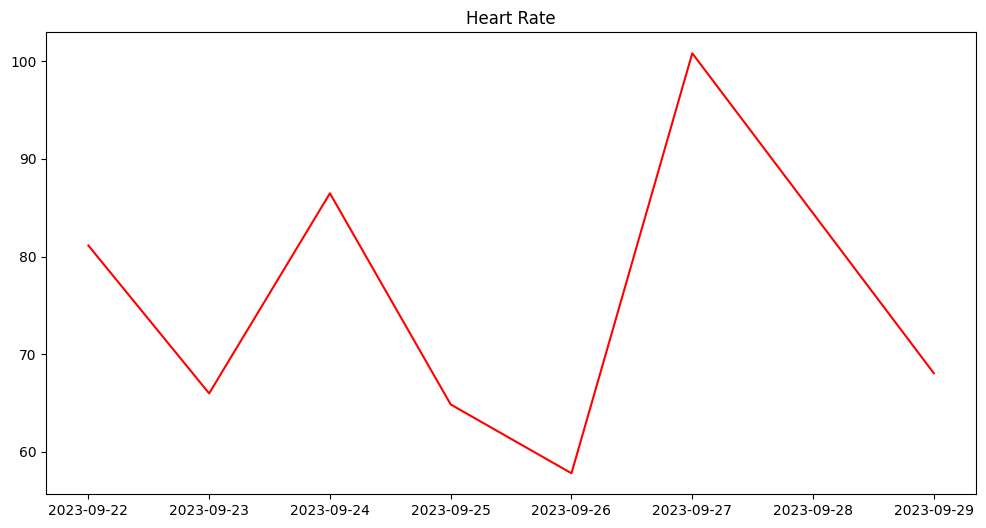

In [19]:
# PLOTTING (Average HeartRate over date range)
hr_data.plot(x='creationDate', y='value', style='r-', markersize=8.5,  figsize=(12, 6))
plt.title('Heart Rate')
plt.show()

In [20]:
# FEATURE EXTRACTION (Calculate entropy (optional), perm_entropy (optional), svd_entropy (optional), mean, min, max, ptp, sum, energy, skewness, kurtosis, peaks, rms, lineintegral, n_above_mean, n_below_mean, iqr, iqr_5_95, pct_5, pct_95)
stats = data.get_statistics(hr_data, True, True, True) # get stats using class method

for k,v in zip(stats.keys(), stats.values()):
  print(f"{k}: {v}")

entropy: 1.9290683749751358
perm_entropy: 0
svd_entropy: -0.0
mean: [75.0180563]
min: [57.80828624]
max: [100.81527905]
sum: [525.12639409]
energy: 40757.71587424592
skewness: 0.6135527831738091
kurtosis: -0.8586953274173066
rms: 76.30550988741238
lineintegral: 140.07208863382778
n_above_mean: 3
n_below_mean: 4
iqr: value    18.384741
dtype: float64
iqr_5_95: value    36.5918
dtype: float64
pct_5: value    59.921679
Name: 0.05, dtype: float64
pct_95: value    96.513479
Name: 0.95, dtype: float64
